<a href="https://colab.research.google.com/drive/1Yh-M4nmlcsqjBGTVXxQErR5LF42KzdqH" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Auto-Encoder(CAE)

In [1]:
''' import '''
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary

from utils import set_all, load_data, split_data, check_data, train, evaluate, plot_hist

In [2]:
''' set '''
device, data_path, output_path = set_all(os.getcwd())

In [3]:
''' load data '''
X, Y = load_data(data_path, '500')
X = X / 255.0
X_tr, X_ts, Y_tr, Y_ts = split_data(X,Y, test_size=0.2, device=device)

print(X_tr.shape, X_ts.shape)
print (Y_tr.shape,Y_ts.shape)

torch.Size([400, 1, 56, 56]) torch.Size([100, 1, 56, 56])
torch.Size([400, 1]) torch.Size([100, 1])


In [5]:
# check_data(X,Y)

In [6]:
''' model '''
class ConvAutoencoder(nn.Module):
    def __init__(self, enc_chs, dec_chs=None):
        super(ConvAutoencoder, self).__init__()

        if dec_chs is None:
            dec_chs = enc_chs[::-1]

        # encoder
        self.encoder = nn.ModuleList()
        in_ch = enc_chs[0] # grayscale
    
        for i in range(len(enc_chs)-2): # relu o
            out_ch = enc_chs[i+1]
            self.encoder.append(nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=2, padding=1))
            self.encoder.append(nn.ReLU())
            in_ch = out_ch

        out_ch = enc_chs[-1] # relu x
        self.encoder.append(nn.Conv2d(in_ch, out_ch, kernel_size=4, stride=2, padding=1))

        # decoder
        self.decoder = nn.ModuleList()
        in_ch = out_ch # dec_chs[0]

        for i in range(len(dec_chs)-2): # relu o
            out_ch = dec_chs[i+1]
            self.decoder.append(nn.ConvTranspose2d(in_ch, out_ch, kernel_size=3, stride=2, padding=1, output_padding=1))
            self.decoder.append(nn.ReLU())
            in_ch = out_ch

        out_ch = dec_chs[-1] # relu x
        self.decoder.append(nn.ConvTranspose2d(in_ch, out_ch, kernel_size=3, stride=2, padding=1, output_padding=1))

    def forward(self, x):
        for conv in self.encoder:
            x = conv(x)
        for conv_T in self.decoder:
            x = conv_T(x)
        return x

## 6. Set model hyperparameters

In [7]:
# cae = ConvAutoencoder(enc_chs=[1, 64, 128, 256], dec_chs=[256, 128, 64, 1]).to(device)

# summary(cae, (1, 56, 56))  # input shape: (channels, height, width)
# cae

In [ ]:
''' hyper params '''

# model
cae = ConvAutoencoder(enc_chs=[1, 64, 128, 256], dec_chs=[256, 128, 64, 1]).to(device)

# hyper param
num_epochs = 50
batch_size = 64
learning_rate = 1e-3

# loss, optim, schaduler
criterion = nn.MSELoss()
optimizer = optim.Adam(params=cae.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=100, gamma=0.9)

# data loader
train_loader = DataLoader(TensorDataset(X_tr, X_tr), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_ts, X_ts), batch_size=len(X_ts))

In [9]:
''' train '''
loss_tr_hist = []
loss_val_hist = []

for epoch in range(num_epochs):

    # train, valid
    loss_tr = train(cae, train_loader, criterion, optimizer)
    loss_val = evaluate(cae, test_loader, criterion)
    scheduler.step()
    
    # history
    loss_tr_hist.append(loss_tr)
    loss_val_hist.append(loss_val)
    print(f'Epoch [{epoch+1:3}/{num_epochs}], Tr loss: {loss_tr:.5f}, Val loss: {loss_val:.5f}')

Epoch [  1/100], Tr loss: 0.55408, Val loss: 0.42784
Epoch [  2/100], Tr loss: 0.25786, Val loss: 0.13143
Epoch [  3/100], Tr loss: 0.12323, Val loss: 0.09312
Epoch [  4/100], Tr loss: 0.07565, Val loss: 0.06482
Epoch [  5/100], Tr loss: 0.05228, Val loss: 0.04440
Epoch [  6/100], Tr loss: 0.04005, Val loss: 0.03533
Epoch [  7/100], Tr loss: 0.03233, Val loss: 0.02892
Epoch [  8/100], Tr loss: 0.02657, Val loss: 0.02365
Epoch [  9/100], Tr loss: 0.02199, Val loss: 0.01963
Epoch [ 10/100], Tr loss: 0.01825, Val loss: 0.01659
Epoch [ 11/100], Tr loss: 0.01574, Val loss: 0.01433
Epoch [ 12/100], Tr loss: 0.01352, Val loss: 0.01242
Epoch [ 13/100], Tr loss: 0.01161, Val loss: 0.01065
Epoch [ 14/100], Tr loss: 0.00994, Val loss: 0.00904
Epoch [ 15/100], Tr loss: 0.00835, Val loss: 0.00767
Epoch [ 16/100], Tr loss: 0.00714, Val loss: 0.00655
Epoch [ 17/100], Tr loss: 0.00602, Val loss: 0.00561
Epoch [ 18/100], Tr loss: 0.00518, Val loss: 0.00476
Epoch [ 19/100], Tr loss: 0.00448, Val loss: 0

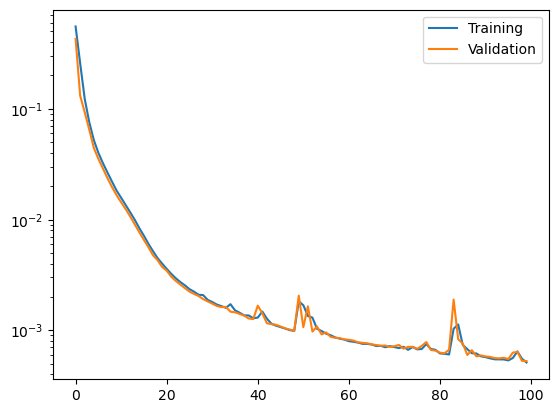

In [10]:
plot_hist(loss_tr_hist, loss_val_hist)

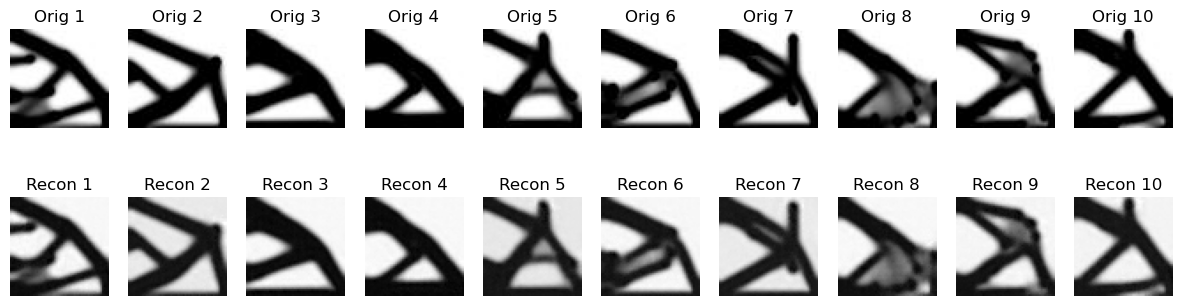

In [11]:
''' evaluation '''
cae.eval()
n = 10

plt.figure(figsize=(15, 4))

for i in range(n):
    
    orig_img = X_ts.squeeze().cpu()[i].reshape(56,56)
    recon_img = cae(X_ts[i]).squeeze().detach().cpu().reshape(56,56)

    # original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(orig_img, cmap="gray")
    plt.title(f"Orig {i+1}")
    ax.axis('off')

    # recon
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(recon_img, cmap="gray")
    plt.title(f"Recon {i+1}")
    ax.axis('off')

plt.show()

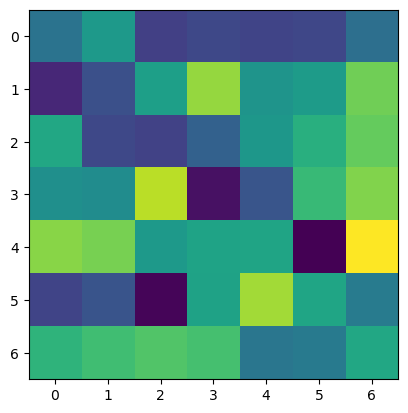

In [12]:
''' visulaize latent space '''
cae.eval()
with torch.no_grad():
    z = X_ts
    for layer in cae.encoder:
        z = layer(z)
    z = z.squeeze().cpu().detach().numpy()   # latent space(z)

plt.imshow(z[0][0])
plt.show()